In [1]:
import os
import sys

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm.autonotebook import tqdm

import pdb

sys.path.append('../')

import random

random.seed(0)
np.random.seed(0)

/home/msesia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [2]:
from simconfcal.models import OutlierDataModel
    
n = 10000
p = 10
model = OutlierDataModel(p, random_state=2020)

X, is_outlier = model.sample(n, purity=0.9)

In [3]:
from simconfcal.outliers import ConformalOutlierDetector
from utils_experiments import evaluate_all_methods
from sklearn.svm import OneClassSVM

def run_experiment(model, method_oneclass, random_state=2021, purity=0.9, num_test=10):   
    # Sample training data
    data, _ = model.sample(n, random_state=random_state)
    
    # Fit one-class classifier
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    if method_oneclass == "SVM":
        clf = OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
    if method_oneclass == "IForest":
        clf = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
    if method_oneclass == "Neighbors":
        clf = LocalOutlierFactor(novelty=True, contamination=contamination)
        
    # Calibrate the conformal classifier
    cconf = ConformalOutlierDetector(data, clf, calib_size=0.5, random_state=random_state)

    # Evaluate performance on test data
    results = pd.DataFrame({})
    for test_index in tqdm(range(num_test)):
        # Sample test data
        random_state_new = random_state + 10000 * test_index
        data_test, is_outlier = model.sample(n, purity=purity, random_state=random_state_new)
        
        for simes_kden in [2,3,4]:
            # Compute p-values on test data
            pvals_one_class = cconf.predict(data_test, delta = 0.05, simes_kden=simes_kden)

            # Evaluate performance
            res = evaluate_all_methods(pvals_one_class, is_outlier)

            # Store results
            res['Simes-k-den'] = simes_kden
            res['Train-index'] = random_state
            res['Test-index'] = test_index
            results = pd.concat([results, res])
    
    return results

In [6]:
method_oneclass = "SVM"

num_train = 2
num_test = 2
purity = 0.9

model = OutlierDataModel(p, a=3.5)
data, _ = model.sample(n)

# Run all the experiments
results = pd.DataFrame({})
for train_index in tqdm(range(num_train)):
    res = run_experiment(model, method_oneclass, random_state=train_index, purity=purity, num_test=num_test)
    results = pd.concat([results, res])

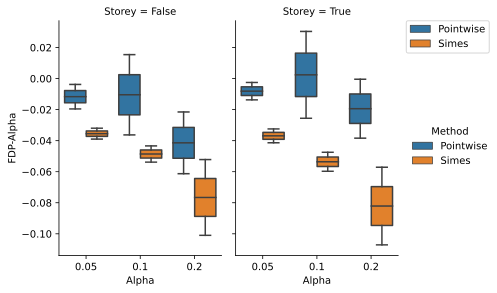

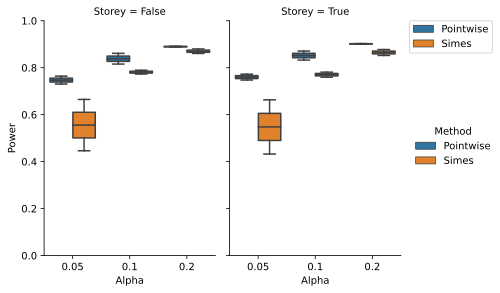

In [7]:
def plot_results(res, col_variable="Storey", average=True):
    res["FDP-Alpha"] = (res["FDP"] - res["Alpha"])
    
    res = res[(res['Alpha']==0.05)|(res['Alpha']==0.1)|(res['Alpha']==0.2)]
    
    if average:
        res = res.groupby(['Method', 'Pi0-true', 'Alpha', 'Train-index', 'Storey']).mean().reset_index()
        
    ax = sns.catplot(x="Alpha", y="FDP-Alpha", hue="Method", col=col_variable, data=res,
                kind="box", height=4, aspect=.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    ax = sns.catplot(x="Alpha", y="Power", hue="Method", col=col_variable, data=res,
                    kind="box", height=4, aspect=.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(0,1)
    plt.show()
    
plot_results(results)